In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from data_reader import bitcoin

In [9]:
mean = bitcoin.mean().to_numpy()
std = bitcoin.std().to_numpy()
bitcoin = (bitcoin - mean) / std
bitcoin['shift'] = bitcoin['Value'].shift(-1)
bitcoin.head()
bitcoin.astype(np.float32)

,Value,shift
Date,,
2016-09-11,-0.824872,-0.825725
2016-09-12,-0.825725,-0.825636
2016-09-13,-0.825636,-0.825786
2016-09-14,-0.825786,-0.825675
2016-09-15,-0.825675,-0.825765
...,...,...
2021-09-06,2.817096,2.881775
2021-09-07,2.881775,2.463925
2021-09-08,2.463925,2.411889


In [10]:
seq_len = 7
train_size = len(bitcoin) - 7
def create_dataset(data, seq_len):
    dataX, dataY = [], []
    for i in range(0, len(data) - seq_len):
        dataX.append(data[['Value']][i: i + seq_len].values)
        dataY.append(data['shift'][i: i + seq_len].values)
    return np.array(dataX, dtype=np.float32), np.array(dataY, dtype=np.float32)
data_X, data_Y = create_dataset(bitcoin, seq_len)
train_x = torch.from_numpy(data_X[: train_size].reshape(-1,seq_len, 1))
train_y = torch.from_numpy(data_Y[: train_size].reshape(-1,seq_len, 1))


In [11]:
class OurPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.reg = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.reg(x)
        return x 

net = OurPredictor(1, 7)





In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.03)

for epoch in range(600):
    out = net(train_x)
    loss = criterion(out, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: {:<3}, Loss:{:.6f}'.format(epoch+1, loss.item()))

Epoch: 1  , Loss:1.197690
Epoch: 2  , Loss:1.091755
Epoch: 3  , Loss:1.013806
Epoch: 4  , Loss:0.952029
Epoch: 5  , Loss:0.905316
Epoch: 6  , Loss:0.863649
Epoch: 7  , Loss:0.800403
Epoch: 8  , Loss:0.700446
Epoch: 9  , Loss:0.578784
Epoch: 10 , Loss:0.466161
Epoch: 11 , Loss:0.377332
Epoch: 12 , Loss:0.307614
Epoch: 13 , Loss:0.252520
Epoch: 14 , Loss:0.211190
Epoch: 15 , Loss:0.183546
Epoch: 16 , Loss:0.170804
Epoch: 17 , Loss:0.170683
Epoch: 18 , Loss:0.172530
Epoch: 19 , Loss:0.175128
Epoch: 20 , Loss:0.182410
Epoch: 21 , Loss:0.189293
Epoch: 22 , Loss:0.193740
Epoch: 23 , Loss:0.194979
Epoch: 24 , Loss:0.192924
Epoch: 25 , Loss:0.187673
Epoch: 26 , Loss:0.179985
Epoch: 27 , Loss:0.170372
Epoch: 28 , Loss:0.159372
Epoch: 29 , Loss:0.151073
Epoch: 30 , Loss:0.146269
Epoch: 31 , Loss:0.143369
Epoch: 32 , Loss:0.141920
Epoch: 33 , Loss:0.141820
Epoch: 34 , Loss:0.142692
Epoch: 35 , Loss:0.143981
Epoch: 36 , Loss:0.144764
Epoch: 37 , Loss:0.144381
Epoch: 38 , Loss:0.142756
Epoch: 39 , 

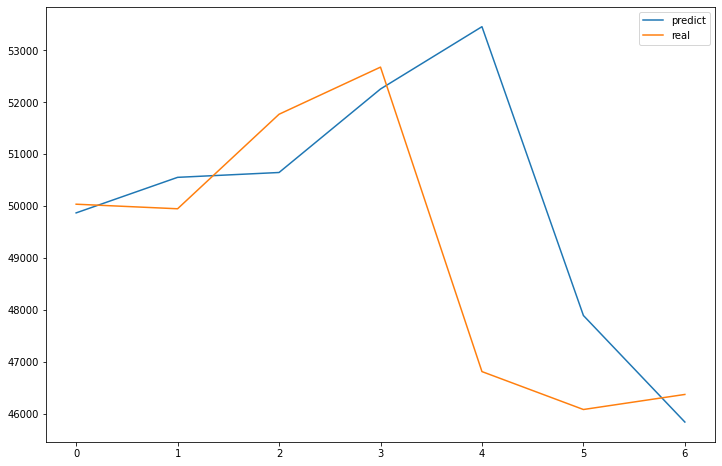

In [19]:
p = net(torch.from_numpy(data_X))[:,-1,0] # 这里只取最后一个预测值作为比较
plt.figure(figsize=(12,8))
plt.plot((p.data.numpy() * std + mean)[-7: ], label= 'predict')
plt.plot((data_Y[:,-1] * std + mean)[-7: ], label = 'real')
plt.legend()


# plt.show()

/home/lyc/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning

7081558.21137105


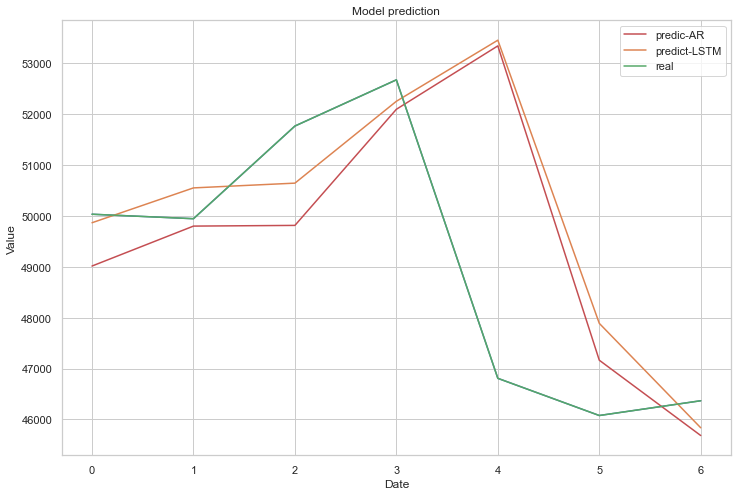

<Figure size 432x288 with 0 Axes>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
import seaborn as sns

sns.set_theme(style='whitegrid')


df = pd.read_csv('../data/BCHAIN-MKPRU.csv',
                 index_col=0, parse_dates=True)
# 把模型数据分为train和test，分别用来训练模型和对比模型预测结果
x = df.values
train, test = x[:-7], x[-7:]  # test的个数设定为7

# 训练模型得到所需参数：AR的滞后项个数p，和自回归函数的各个系数
model_fit = AR(train).fit()
params = model_fit.params
p = model_fit.k_ar  # 即时间序列模型中常见的p，即AR(p), ARMA(p,q), ARIMA(p,d,q)中的p。
# p的实际含义，此处得到p=29，意味着当天的温度由最近29天的温度来预测。
history = train[-p:]   
history = np.hstack(history).tolist()  # 也可以用history = [history[i] for i in range(len(history))] ，
# 唯一的目的就是接下来通过append(test[i])实时更新history
# （append函数不适用于np.narray类型的history）
test = np.hstack(test).tolist()

predictions = []
for t in range(len(test)):
	lag = history[-p:]
	yhat = params[0]
	for i in range(p):
		yhat += params[i+1] * lag[p-1-i]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
print(np.mean((np.array(test) - np.array(predictions))**2))  # 得到mean_squared_error, MSE
# plt.show()
plt.figure(figsize=(12, 8))
plt.plot(test)
plt.plot(predictions, color='r', label='predic-AR')
plt.title("Model prediction")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(['Actual value', 'predicted value'], loc='upper right', fontsize=10)
# plt.show()
# plt.savefig('autoregression4.png',dpi=600,format='png')
p = net(torch.from_numpy(data_X))[:,-1,0] # 这里只取最后一个预测值作为比较
plt.plot((p.data.numpy() * std + mean)[-7: ], label= 'predict-LSTM')
plt.plot((data_Y[:,-1] * std + mean)[-7: ], label = 'real')
plt.legend()
plt.savefig('../img/two_stage_predict.png', bbox_inches='tight', dpi=1080)

In [16]:
bitcoin.shape

(1826, 2)